# Analysing Political Executives with AI

In [107]:
# Install the packages for data anlysis in Python
# Install the packages for data analysis and visualisation
!pip3 install seaborn pandas matplotlib numpy IPython openpyxl

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Alternative to set svg for newer versions
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Showing all the details of results
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Built a total dataset

- Merging data from other files
- Read the data from Archigos excel document/dta data


In [109]:
# Read the original dta(Stata) data download from Archigos website.
# load the data
datafile = 'Archigos_4.1_stata14.dta'
data = pd.read_stata(datafile)

# Startdate is better than eindate, enddate is better than eoutdate
# Change the data type of startdate and enddate to datatime
data['startdate'] = data['startdate'].astype('datetime64[ns]')
data['enddate'] = data['enddate'].astype('datetime64[ns]')
data['yrbegin'] = pd.DatetimeIndex(data['startdate']).year
data['yrend'] = pd.DatetimeIndex(data['enddate']).year

# Import the data about countries grouped by three categories: Autocracy, Anocracy, Democracy
data_deau = pd.read_excel('DeorAu_group.xlsx')

# load another excel file mpd2020 with gdppc and pop
data_mpd2020 = pd.read_excel('mpd2020.xlsx', 'Full data')

# Combine data_deau with data_leader with key id=countries
# Rename the Country-id to idacr in data_deau
data_deau = data_deau.rename({'Country-id': 'idacr'}, axis='columns')
data_leader_deau = pd.merge(data, data_deau, how ='left', on ='idacr')

# Rename the countrycode to idacr in data_mpd2020
# Rename the year in gdppc to yrend to merge data
data_mpd2020 = data_mpd2020.rename({'countrycode': 'idacr', 'year': 'yrend'}, axis='columns')

# Change the float to int
data_leader_deau['yrend'] = data_leader_deau['yrend'].fillna(0.0).astype(int)
data_leader_deau['yrbegin'] = data_leader_deau['yrbegin'].fillna(0.0).astype(int)

# Combine data_leaders_deau with data_mpd2020 with key idacr and year
data_leader_deau_gdp = pd.merge(data_leader_deau, data_mpd2020, how ='left', on =['idacr', 'yrend'])

# Rename the gdppc to end_gdppc in data_leaders_deau_gdp
data_leader_deau_gdp = data_leader_deau_gdp.rename({'gdppc': 'end_gdppc'}, axis='columns')

data_gdp = pd.read_excel('data_gdp.xlsx')
data_gdp = data_gdp.rename({'year': 'yrbegin'}, axis='columns')
data_all = pd.merge(data_leader_deau_gdp, data_gdp, how ='left', on =['idacr', 'yrbegin'])

# Rename the gdppc to begin_gdppc in data_all
data_all = data_all.rename({'gdppc': 'begin_gdppc'}, axis='columns')

# Calculate the leaders' age, when they first into power
# See the characteristics of yrborn, there is something wrong in the data. 
# Because I change the data type of yrborn, from int to datetime.

# age= yrbegin- yrborn
data_all['age'] = data_all['yrbegin'] - data_all['yrborn']

# See the distribution of age
# data_all.groupby(['age']).mean()

C:\Users\my\miniconda3\envs\DS\lib\site-packages\pandas\io\stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


## Calculate their tenure
 
- Calculate the tenure
- Check the data about our data about tenure 
- Delete tenure < 1
- Group the data by leaders and sum their tenure together ？？

In [110]:
# tenure= enddate or eoutdate - startdate  or  eindate (Unit: years)
# if enddate is null, it has two possibilities: 
# 1. leader is still in office, use the date now; 2. not available.  

import datetime

data_all['startdate'] = pd.to_datetime(data_all['startdate']).dt.date
data_all['enddate'] = pd.to_datetime(data_all['enddate']).dt.date

data_all['enddate'] = np.where(data_all['enddate'].isnull(),
                                datetime.datetime.now().date(),
                                data_all['enddate'])

data_all['tenure'] = (data_all['enddate'] - data_all['startdate'])/np.timedelta64(1, 'Y')

# data_all.groupby(['tenure']).mean()

data_all.drop(data_all[data_all['tenure'] < 1].index , inplace=True)

# Add tenure to the excel grouped by leaders
# Some leaders may have more than one term
# Tenure: merge the duplicates and sum the tenure.
# data_all=data_all.groupby(['leader']).sum()

# Check if there are any abonormal data_all.
# data_all.groupby(['tenure']).mean()

In [111]:

# calulate the growth rate
data_all['growth_rate'] = (data_all['end_gdppc'] / data_all['begin_gdppc'] - 1) / data_all['tenure']

# data_all.describe()

data_all.dropna(subset = ['growth_rate'], inplace=True)

## Data cleaning

### Delete the irrelevant data with irrelevant columns

In [112]:
# 'country_x','country_y'
data_all.drop(columns=['obsid',
                   'leadid',
                   'idacr',
                   'startdate',
                   'eindate',
                   'enddate',
                   'eoutdate',
                   'borndate',
                   'ebirthdate',
                   'deathdate',
                   'edeathdate',
                   'dbpediauri',
                  'numexitcode',
                  'numposttenurefate',
                  'ftcur',
                  'Country',
                  'Polity datasets IV number[11][12]',
                  'Polity datasets IV category'], inplace=True)

# Deal with family ties and gender 
data_all['fties_range'] = np.where(data_all['fties'].isnull(), 0.5, 1)
data_all['gender'] = np.where(data_all['gender']=='M', 0.5, 1)


data_all.drop(columns=['fties',
                       'Democracy',
                       'Autocracy'], inplace=True)
                       
# Delete the columns that more than 30% is null 
# Delete the column >= 30% is null, we can see the remaining column names.
null_sum=data_all.isnull().sum()
data_all.columns[null_sum<len(data_all)*0.3] # columns will keep

# Drop the columns that at least 30% values are null
data_all.drop(columns=data_all.columns[null_sum > len(data_all)*0.3], inplace=True)

# Check if there are any abnormal values, we need to pay attention to the negative numbers. 
# Some leaders are still alive, so the yrdied is negative number, etc.
# print(data.describe())

Index(['ccode', 'leader', 'entry', 'exit', 'exitcode', 'prevtimesinoffice',
       'posttenurefate', 'gender', 'yrborn', 'yrdied', 'numentry', 'numexit',
       'yrbegin', 'yrend', 'country', 'end_gdppc', 'pop_x', 'begin_gdppc',
       'pop_y', 'age', 'tenure', 'growth_rate', 'fties_range'],
      dtype='object')

In [113]:
data_all.dropna(subset = ['leader'], inplace=True)

In [114]:
# First we see the characteristics of entry, there are four different kinds of types.
# data.groupby(['entry']).mean()

# Group the leaders by entry, see the compare between each group.
# ax= sns.histplot(data['entry'])

# Second we see the characteristics of exit, there are eight different kinds of types.
# data.groupby(['exit']).mean()

# Group the leaders by exit, see the compare between each group.
# sns.countplot(y='exit',data=data)

In [115]:
# Delete if yrbegin > yrend, age < 0
# print(data_all[data_all['yrbegin'] > data_all['yrend']]) #age < 0
data_all.drop(data_all[data_all['yrbegin'] > data_all['yrend']].index, inplace=True)

# Delete the data_all yrbegin < 0, yrend < 0, yrborn<0, yrdied<0
data_all.drop(data_all[data_all['yrborn']<0].index , inplace=True) 
# data_all.drop(data_all[data_all['yrdied']<0].index, inplace=True)
data_all.drop(data_all[data_all['yrbegin']<0].index , inplace=True) 
data_all.drop(data_all[data_all['yrend']<0].index, inplace=True)
# print(data_all.shape)

# Find if yrbegin > yrdied, lifespan < 0 
# print(data_all[data_all['yrbegin'] > data_all['yrdied']]) # begin to come into power after the leader is died.

# Delete the data_all yrbegin > yrdied
# data_all.drop(data_all[data_all['yrbegin'] > data_all['yrdied']].index, inplace=True) 

### Duplicated leader with more than one age, we pick up the first??

In [116]:
# # Find duplicates and sum the duplicates.
# print(data.leader.duplicated().sum())

# # Sum the non-duplicates.
# print((~data.leader.duplicated()).sum())

# # The first occurrence gets kept, and all others get identified as duplicates
# data.leader=data.leader.drop_duplicates(keep='first')

# # Save the groupby leader dataframe
# data_leader = data.groupby(['leader'])
# data.to_excel(r'data_all_leaders_group.xlsx', index = False)

# print(data_leader.dtypes)

# data_leader.describe()

### Draw a figure about age

In [117]:
# # See the distribution of age
# import seaborn as sns
# ax = sns.histplot(data.age, kde=True)

# import seaborn as sns
# sns.histplot(data.age,bins=[1, 30, 40, 50, 60, 70, 80, 90] ,color = 'orange', shrink=.9)

### Group the tenure into five possible values

- 1 for single term - equal to or less than 4 years; 
- 2 for two terms - between 5 and 8 years;
- 3 for three terms -  between 9 and 12 years;
- 4 for four terms - between 13 and 16 years;
- 5 for five or more terms)</font> 

In [118]:
# Divied tenure group to five groups
# tenure_groups= pd.cut(data['tenure'], bins=[1, 4, 8, 12, 16, 20, np.inf])
# data.groupby(tenure_groups).mean()

# See the distribution of tenure
# ax = sns.histplot(data.tenure,kde=True, shrink = 0.8, bins=20) 

                 #, element="step", fill=False)

In [119]:
# See the distribution of tenure
# sns.histplot(data.tenure,bins=[0, 4, 8, 12, 16, 20, np.inf], color = 'pink', shrink=.9)

In [120]:
# data.dtypes

# Visualize the differences about leaders' gender for the whole data set
# ax= sns.histplot(data.gender, shrink = 0.8, bins=10, color='grey') 

In [121]:
# # The correlations of all the variables used in this study sample: leaders' age, leaders' tenure
# corr= data.corr()
# corr

# # Visualize the corelation between each column
# fig = plt.figure(figsize =(8,8))
# plt.matshow(corr, cmap='RdBu', fignum = fig.number)
# plt.xticks(range(len(corr.columns)), corr.columns, rotation = 'vertical');
# plt.yticks(range(len(corr.columns)), corr.columns);

In [122]:
# The relationship between age and tenure
# data.plot(kind = 'scatter', x = 'age', y = 'tenure', figsize = (6,6))

# Save the py file to excel
# data.to_excel('data_all_leaders_group.xlsx', index = False)
# Tranfert the .py file to excel

In [123]:
# import seaborn as sns
# ax= sns.histplot(data_all['growth_rate'])

In [124]:
# import numpy as np
# data['fties_range'] = np.where(data['fties'].isnull(), 0.5, 1)
# data['gender'] = np.where(data['gender']=='M', 0.5, 1)
#data['logarithm_gdppc'] = np.log(data['gdppc'])
#data['normal_tenure'] = (data['tenure'] - data['tenure'].mean()) / data['tenure'].std()#normalize tenure with z-score

In [125]:
# corr= data.corr()

# #visualize the corelation between each column
# fig = plt.figure(figsize =(8,8))
# #plt.matshow(corr, cmap='RdBu', fignum = fig.number)
# plt.xticks(range(len(corr.columns)), corr.columns, rotation = 'vertical');
# sns.heatmap(corr, cmap='RdBu')
# plt.yticks(range(len(corr.columns)), corr.columns)
# fig.savefig('heatmap.png',dpi=600)

### Normalization

In [126]:
# ccode int
min, max = data_all['ccode'].min(), data_all['ccode'].max()
data_all['ccode'] = (data_all['ccode']-min)/(max-min)

# entry, regular 1...
data_all['entry'] = data_all['entry'].replace({'Regular': 1,'Irregular': 2, 'Foreign Imposition': 3})
data_all['entry']=data_all['entry'].astype(float, errors='raise')
min, max = data_all['entry'].min(), data_all['entry'].max()
data_all['entry']= (data_all['entry']-min)/(max-min)

# exit, regular 1...
data_all['exit'] = data_all['exit'].replace({'Regular': 1, 'Irregular': 2, 'Foreign': 3,'Natural Death': 4, 
                                    'Retired Due to Ill Health': 5, 'Suicide': 6}) 
                                    
data_all['exit']=data_all['exit'].astype(float, errors='raise')
min, max = data_all['exit'].min(), data_all['exit'].max()
data_all['exit']= (data_all['exit']-min)/(max-min)

# exitcode, regular 1...
data_all['exitcode'] = data_all['exitcode'].replace({'Assassination by Unsupported Individual': 1,'Irregular, Other': 2,
                                             'Popular Protest, with Foreign Support': 3, 
                                             'Popular Protest, without Foreign Support': 4,
                                             'Regular': 5, 'Removed by Military, with Foreign Support': 6,
                                             'Removed by Military, without Foreign Support': 7, 
                                             'Removed by Other Government Actors, with Foreign Support': 8,
                                             'Removed by Other Government Actors, without Foreign Support': 9,
                                             'Removed by Rebels, with Foreign Support': 10,
                                             'Removed by Rebels, without Foreign Support': 11,
                                             'Removed in Military Power Struggle Short of Coup': 12,
                                             'Removed through Threat of Foreign Force': 13, 'Unknown':14}) 
data_all['exitcode']=data_all['exitcode'].astype(float, errors='raise')
min, max = data_all['exitcode'].min(), data_all['exitcode'].max()
data_all['exitcode']= (data_all['exitcode']-min)/(max-min)

ValueError: could not convert string to float: 'Still in Office'

(613, 23)

0.017681165402229724
0.04440134066224207


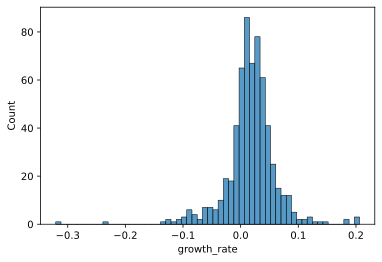

In [ ]:
# posttenurefate
data_all['posttenurefate'] = data_all['posttenurefate'].replace({'Death': 1, 'Exile': 2, 'Imprisonment': 3, 
                                     'Missing: Natural Death within Six Months of Losing Office': 4,
                                     'Missing: No Information Found': 5, 'OK': 6, 'Suicide': 7}) 
data_all['posttenurefate']=data_all['posttenurefate'].astype(float, errors='raise')
min, max = data_all['posttenurefate'].min(), data_all['posttenurefate'].max()
data_all['posttenurefate']= (data_all['posttenurefate']-min)/(max-min)

# prevtimesinoffice
min, max = data_all['prevtimesinoffice'].min(), data_all['prevtimesinoffice'].max()
data_all['prevtimesinoffice']= (data_all['prevtimesinoffice']-min)/(max-min)

# yrborn
min, max = data_all['yrborn'].min(), data_all['yrborn'].max()
data_all['yrborn']= (data_all['yrborn']-min)/(max-min)

# yrdied
min, max = data_all['yrdied'].min(), data_all['yrdied'].max()
data_all['yrdied']= (data_all['yrdied']-min)/(max-min)

# numentry
min, max = data_all['numentry'].min(), data_all['numentry'].max()
data_all['numentry']= (data_all['numentry']-min)/(max-min)

# numexit
min, max = data_all['numexit'].min(), data_all['numexit'].max()
data_all['numexit']= (data_all['numexit']-min)/(max-min)

# yrbegin
min, max = data_all['yrbegin'].min(), data_all['yrbegin'].max()
data_all['yrbegin']= (data_all['yrbegin']-min)/(max-min)

# yrend
min, max = data_all['yrend'].min(), data_all['yrend'].max()
data_all['yrend']= (data_all['yrend']-min)/(max-min)

# age
min, max = data_all['age'].min(), data_all['age'].max()
data_all['age']= (data_all['age']-min)/(max-min)

# tenure
min, max = data_all['tenure'].min(), data_all['tenure'].max()
data_all['tenure']= (data_all['tenure']-min)/(max-min)

# end_gdppc
min, max = data_all['end_gdppc'].min(), data_all['end_gdppc'].max()
data_all['end_gdppc']= (data_all['end_gdppc']-min)/(max-min)

# pop_x
min, max = data_all['pop_x'].min(), data_all['pop_x'].max()
data_all['pop_x']= (data_all['pop_x']-min)/(max-min)

# begin_gdppc
min, max = data_all['begin_gdppc'].min(), data_all['begin_gdppc'].max()
data_all['begin_gdppc']= (data_all['begin_gdppc']-min)/(max-min)

# pop_y
min, max = data_all['pop_y'].min(), data_all['pop_y'].max()
data_all['pop_y']= (data_all['pop_y']-min)/(max-min)

data_all.dropna(subset = ['growth_rate'], inplace=True)
data_all.shape

# Look at the distribution of the data_all put into the model
ax = sns.histplot(data_all['growth_rate'])

mean = data_all['growth_rate'].mean()
std = data_all['growth_rate'].std()
print(mean)
print(std)

0       0.003934
1       0.059757
3       0.004888
4       0.010956
5       0.004793
          ...   
3242    0.013632
3243    0.010468
3245    0.021145
3246    0.033296
3247    0.059328
Name: growth_rate, Length: 613, dtype: float64
(array([  1,   1,   0,   4,  24,  90, 403,  77,   8,   5], dtype=int64), array([-0.32076286, -0.26805651, -0.21535016, -0.16264381, -0.10993745,
       -0.0572311 , -0.00452475,  0.0481816 ,  0.10088796,  0.15359431,
        0.20630066]))


(array([ 0.30951134,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.30951134,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.30951134,
         0.        ,  0.30951134,  0.30951134,  0.30951134,  0.        ,
         0.61902268,  0.30951134,  0.30951134,  1.23804536,  0.92853402,
         0.92853402,  0.30951134,  0.30951134,  1.23804536,  1.23804536,
         1.85706804,  0.61902268,  0.92853402,  1.5475567 ,  1.85706804,
         3.09511341,  3.09511341,  2.78560207,  3.71413609,  8.3568062 ,
        10.52338558, 12.38045363, 13.92801033, 16.7136124 , 12.99947631,
        12.38045363, 12.68996497, 11.14240827, 11.1

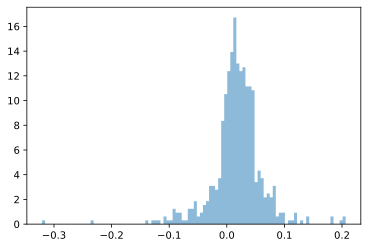

In [ ]:
x = data_all['growth_rate']
y = np.histogram(data_all['growth_rate'])
print(x)
print(y)

plt.hist(data_all['growth_rate'], bins=100, density=True, alpha=0.5, histtype='stepfilled' )

In [ ]:
from scipy.stats import norm

# Group growth_rate into seven groups according to the central limit theorem
mu, std = norm.fit(data_all['growth_rate'])
conditions = [
    (data_all['growth_rate'] < -mu-3*std),
    (data_all['growth_rate'] >= -mu-3*std) & (data_all['growth_rate'] < -mu-2*std),
    (data_all['growth_rate'] >= -mu-2*std) & (data_all['growth_rate'] < -mu-std),
    (data_all['growth_rate'] >= -mu-std) & (data_all['growth_rate'] < mu+std),
    (data_all['growth_rate'] >= mu+std) & (data_all['growth_rate'] < mu+2*std),
    (data_all['growth_rate'] >= mu+2*std) & (data_all['growth_rate'] < mu+3*std),
    (data_all['growth_rate'] >= mu+3*std)
]

values = [7, 6, 5, 4, 3, 2, 1]

data_all['growth_rate_normgroup'] = np.select(conditions, values)

In [ ]:
# Group growth_rate into seven groups according to min and max
min, max = data_all['growth_rate'].min(), data_all['growth_rate'].max()
conditions = [
    (data_all['growth_rate'] < min+1/7*(max-min)),
    (data_all['growth_rate'] >= min+1/7*(max-min)) & (data_all['growth_rate'] < min+2/7*(max-min)),
    (data_all['growth_rate'] >= min+2/7*(max-min)) & (data_all['growth_rate'] < min+3/7*(max-min)),
    (data_all['growth_rate'] >= min+3/7*(max-min)) & (data_all['growth_rate'] < min+4/7*(max-min)),
    (data_all['growth_rate'] >= min+4/7*(max-min)) & (data_all['growth_rate'] < min+5/7*(max-min)),
    (data_all['growth_rate'] >= min+5/7*(max-min)) & (data_all['growth_rate'] < min+6/7*(max-min)),
    (data_all['growth_rate'] >= min+6/7*(max-min))
]
    
values = [7, 6, 5, 4, 3, 2, 1]

data_all['growth_rate_avggrp'] = np.select(conditions, values)

In [66]:
# Save dataset to CSV file for AutoGluon
data_all.to_csv(r'data_AutoGluon.csv', index = False)

In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Generate some data_all for this
# demonstration.
dta = data_all['growth_rate']

# Fit a normal distribution to
# the data_all:
# mean and standard deviation
mu, std = norm.fit(dta)

# Plot the histogram.
plt.hist(dta, bins=100, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
# title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
# plt.title(title)

plt.show()


In [ ]:
# group growth_rate in desc
sorted_data = data.sort_values("growth_rate", ascending=False)

In [ ]:
# Group leaders into seven groups each group with approximately same leaders, the rest is placed in the last group
groups = range(1,8)
data['growth_rate_avggrp'] = np.concatenate(
                [np.repeat(groups,int(len(data)/7)), 
                 np.repeat([7],int(len(data)%7))])

In [ ]:
ax = sns.histplot(data['growth_rate_avggrp'])

In [ ]:
ax = sns.histplot(data['age'])

In [ ]:
ax = sns.histplot(data['tenure'])

In [ ]:
ax = sns.histplot(data_com3['gender'])

In [ ]:
ax = sns.histplot(data['normal_tenure'])

In [ ]:
#drop growth_rate
data.drop(['growth_rate'], axis=1, inplace=True)

In [ ]:
#delete growth_rate
data.drop([  
'growth_rate'
], axis=1, inplace=True)